In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy import genfromtxt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
sns.set_style('whitegrid', {'axes_linewidth': 0, 'axes.edgecolor': 'white'})

In [19]:
def is_significant(value, confidence_interval, threshold="conf"):
    if threshold == "conf":
        return value - abs(confidence_interval) > 0
    else:
        return value - abs(float(threshold)) > 0
 
def grouped_radial(SAresults, parameters, radSc=2.0, scaling=1, widthSc=0.5, STthick=1, varNameMult=1.3, colors=None, groups=None, gpNameMult=1.5, threshold="conf"):
    # Derived from https://github.com/calvinwhealton/SensitivityAnalysisPlots
    fig, ax = plt.subplots(1, 1)
    color_map = {}
     
    # initialize parameters and colors
    if groups is None:
         
        if colors is None:
            colors = ["k"]
         
        for i, parameter in enumerate(parameters):
            color_map[parameter] = colors[i % len(colors)]
    else:        
        if colors is None:
            colors = sns.color_palette("deep", max(3, len(groups)))
         
        for i, key in enumerate(groups.keys()):
            #parameters.extend(groups[key])
             
            for parameter in groups[key]:
                color_map[parameter] = colors[i % len(colors)]
     
    n = len(parameters)
    angles = radSc*math.pi*np.arange(0, n)/n
    x = radSc*np.cos(angles)
    y = radSc*np.sin(angles)
     
    # plot second-order indices
    for i, j in itertools.combinations(range(n), 2):
        #key1 = parameters[i]
        #key2 = parameters[j]
         
        if is_significant(SAresults["S2"][i][j], SAresults["S2_conf"][i][j], threshold):
            angle = math.atan((y[j]-y[i])/(x[j]-x[i]))
                 
            if y[j]-y[i] < 0:
                angle += math.pi
                 
            line_hw = scaling*(max(0, SAresults["S2"][i][j])**widthSc)/2
                 
            coords = np.empty((4, 2))
            coords[0, 0] = x[i] - line_hw*math.sin(angle)
            coords[1, 0] = x[i] + line_hw*math.sin(angle)
            coords[2, 0] = x[j] + line_hw*math.sin(angle)
            coords[3, 0] = x[j] - line_hw*math.sin(angle)
            coords[0, 1] = y[i] + line_hw*math.cos(angle)
            coords[1, 1] = y[i] - line_hw*math.cos(angle)
            coords[2, 1] = y[j] - line_hw*math.cos(angle)
            coords[3, 1] = y[j] + line_hw*math.cos(angle)
 
            ax.add_artist(plt.Polygon(coords, color="0.75"))
         
    # plot total order indices
    for i, key in enumerate(parameters):
        if is_significant(SAresults["ST"][i], SAresults["ST_conf"][i], threshold):
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["ST"][i]**widthSc)/2, color='w'))
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["ST"][i]**widthSc)/2, lw=STthick, color='0.4', fill=False))
     
    # plot first-order indices
    for i, key in enumerate(parameters):
        if is_significant(SAresults["S1"][i], SAresults["S1_conf"][i], threshold):
            ax.add_artist(plt.Circle((x[i], y[i]), scaling*(SAresults["S1"][i]**widthSc)/2, color='0.4'))
            
    # add labels
    for i, key in enumerate(parameters):                
        ax.text(varNameMult*x[i], varNameMult*y[i], key, ha='center', va='center',
                rotation=angles[i]*360/(2*math.pi) - 90,
                color=color_map[key])
         
    if groups is not None:
        for i, group in enumerate(groups.keys()):
            print(group)
            group_angle = np.mean([angles[j] for j in range(n) if parameters[j] in groups[group]])
             
            ax.text(gpNameMult*radSc*math.cos(group_angle), gpNameMult*radSc*math.sin(group_angle), group, ha='center', va='center',
                rotation=group_angle*360/(2*math.pi) - 90,
                color=colors[i % len(colors)])
             
    ax.set_facecolor('white')
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.
    plt.axis('equal')
    plt.axis([-2*radSc, 2*radSc, -2*radSc, 2*radSc])
    #plt.show()
 
     
    return fig

In [3]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import math
from SALib.sample import saltelli
from SALib.analyze import sobol

### Range of soil parameters

In [4]:
problem = {
    'num_vars':6,
    'names':['SOC', 'Sand', 'Clay', 'pH', 'CN', 'BD'],
    'bounds':[[2.58, 6.20],
              [0.01, 0.30],
              [0.01, 0.30],
              [4.6, 6.9],
              [10.9, 12.4],
              [900, 1350]]
}

In [5]:
#names for csv files
list_of_csv=['soybean-000-2015.csv', 'sugar-beet-2011.csv', 'sugar-beet-2017.csv',
'spring-barley-2012.csv', 'sugar-beet-2014.csv']
list_of_names=['soybean-000-2015', 'sugar-beat-2011', 'sugar-beat-2017',
'spring-barley-2012', 'sugar-beat-2014']
list_of_totals=['total_SI_'+x for x in list_of_names]
list_of_first=['fisrt_SI_'+x for x in list_of_names]
list_of_second=['second_SI_'+x for x in list_of_names]
list_of_SI=['SI_'+x for x in list_of_names]

#### Sensitivity analysis by Sobol

In [6]:
for j, i in enumerate(list_of_csv):
#     for j in range(len(list_of_csv)):
        all_data_csv = genfromtxt('./'+str(i), delimiter=',')
        output = all_data_csv[:,2]
        print(i)
        list_of_SI[j] = sobol.analyze(problem, output, calc_second_order=True, conf_level=0.95, print_to_console=False)
#         list_of_totals[j], list_of_first[j], list_of_second[j] = Si.to_df()
#         str(i)+'total_Si'=total_Si

soybean-000-2015.csv
sugar-beet-2011.csv
sugar-beet-2017.csv
spring-barley-2012.csv
sugar-beet-2014.csv


Soil physics
Soil chemistry


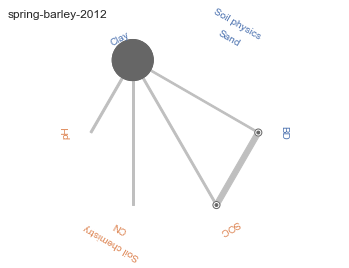

In [20]:
groups={"Soil physics" : ["Sand", "Clay", "BD"],
        "Soil chemistry" : ["pH", "SOC", "CN"]}
 

fig = grouped_radial(list_of_SI[1], ['BD', 'Sand', 'Clay', 'pH', 'CN', 'SOC'], groups=groups, threshold=0.001)
red_patch = mpatches.Patch(color='red', label='The red data')
plt.title(list_of_names[3], loc='left')

plt.show()

# plt.savefig('grafik.png', dpi=300)

In [21]:
# groups={"Soil physics" : ["Sand", "Clay", "BD"],
#         "Soil chemistry" : ["pH", "SOC", "CN"]}
# for i in range(len(list_of_SI)):
#     print(list_of_names[i])
#     fig = grouped_radial(list_of_SI[i], ['BD', 'Sand', 'Clay', 'pH', 'CN', 'SOC'], groups=groups, threshold=0.001, radSc=2.0, \
#     scaling=1, widthSc=0.4, STthick=2, varNameMult=1.4, gpNameMult=1.6,)
#     plt.show()
# #     plt.title(list_of_names[i], loc='left')
# #    plt.savefig(list_of_names[i]+'.png', dpi=500)